# SET: 23-11-06


In [49]:
# Importing standard data analysis and visualization libraries
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For advanced data visualization
import matplotlib.pyplot as plt  # For basic plotting and visualization
from scipy.stats import ttest_ind, mannwhitneyu  # For statistical tests
from sklearn.cluster import KMeans

# Importing custom utility functions for specific data processing tasks
from Utils_ipynb import (
    append_csv_files_from_subfolders,  # Function to concatenate CSV files from subfolders
    extract_and_append_image_info,  # Function to extract and append image information from data
    filter_dataframe,  # Function to filter data based on specific criteria
    get_correlation_matrices_plt,  # Function to create and plot correlation matrices
    refine_and_filter_data , # Function to refine and further filter data
    plot_metrics_by_group_and_ring
)

# Settings

In [50]:
RING_COEFF_CUT_OFF = 1.2

## Data Preparation

### Step 1: Data Read
- **Objective**: Combine 'cell_stat.csv' files from various subdirectories within a specified root folder into a single DataFrame.
- **Context**: This step aggregates data collected from parallel analyses conducted on the Borah cluster.
- **Data Format**: Each 'cell_stat.csv' file contains [brief description of data, like columns and typical values].
- **Note**: [Any specific filters or considerations applied during aggregation, if applicable].



In [51]:
# Read files from each subdirctory
root_folder = r'C:\Users\nnina\Documents\BioLab_C\Current_experiments_C\Anamaria_3d_experiment_C\23-11-06_LSM\analysis_data'
combined_df = append_csv_files_from_subfolders(root_folder)
combined_df

,Image_name,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre","Nucleus_cylinder, pixels_number","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 sum_pix_in_nuc_cylinder,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 sum_pix_in_nuc_cylinder,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 sum_pix_in_nuc_cylinder,AF488-T3 has ring,AF488-T3 ring intensity coef
0,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,0,0,461.643895,996930,27.046086,17.605471,3.91,2527.432704,1719942367,False,0.921817,864.017826,698693974,True,1.174846,2401.808432,1791736329,True,1.148693
1,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,0,1,483.243250,965238,18.115775,25.089923,3.45,3287.811670,1862992625,False,0.880129,561.337495,384510719,True,1.124206,3135.247164,1881412731,True,1.081083
2,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,1,0,584.321411,1124960,18.541028,16.925067,4.83,5287.825658,2897109348,False,0.798187,497.096685,411506524,True,1.603310,3898.721917,2333784273,True,1.226675
3,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,1,1,586.277123,911744,15.819409,16.840016,5.52,4942.411669,3048949604,False,0.678899,486.145889,432071385,True,1.850022,3216.833939,2220515977,True,1.116455
4,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,1,2,526.012718,1943680,21.943051,25.345075,7.13,2696.254186,2241910411,True,1.008824,182.770924,222705345,True,1.042673,2405.867156,2018340713,True,1.091775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,48,2,784.626002,2320640,28.576997,26.280631,5.98,2038.030541,2503193324,False,0.870536,123.987522,215957217,False,0.928179,305.384805,394996478,False,0.690209
1977,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,48,3,425.651624,1244208,17.435370,25.430125,5.29,1972.499314,1379121101,False,0.709455,106.588674,125226880,False,0.839584,264.252680,215649236,False,0.557720
1978,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,48,4,329.505587,1058764,18.796179,19.476584,5.75,2124.897135,1241357429,False,0.815135,127.809957,104292939,False,0.915964,277.313742,172283116,False,0.743163
1979,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,48,5,450.213248,1175132,20.156989,18.370927,5.29,2304.727063,1408837151,False,0.745369,128.939479,120135034,False,0.921926,435.221600,275712063,False,0.518293


#### Step 2: Extraction of Experimental Setup and Group Information from Image Names
Extraction detailed information about the experimental setup and group, as well as the processing type, directly from the 'Image_name' column in our DataFrame. This is achieved through the extract_and_append_image_info function. The 'Image_name' column is a rich source of data, encapsulating key aspects of the experiment and image processing in a condensed format:
- Processing: Indicates the type of image processing used, such as 'RAW' or 'LSM'.
- Date: The date when the image was captured.
- Time: Time point of the experiment, typically 0, 24, or 48 hours.
- Cell Type: Identifies the cell type, e.g., 'KASH', 'KASH+doxy', or 'MSC'.
- LIV: Indicates the presence (+LIV) or absence (-LIV) of LIV in the sample.
- Cisp: Shows the concentration of Cisplatin used, or 'Control' if not applicable.

In [52]:
enhanced_df = extract_and_append_image_info(combined_df, 'Image_name')

#### Step 3: Removing Inaccurate Nuclei Detections
Although the 3D Signal Detector generally performs well in identifying signals within the nucleus area, manual verification of each image is still necessary. This step ensures the accurate processing of nuclei, particularly for retaining edge cells. While edge cells are often removed, some that are barely touching the image's edge may be viable for analysis and are, therefore, preserved.

Another challenge involves distinguishing between dividing nuclei and those with irregular shapes. While automation is possible for this task, we have chosen to assess the processed data manually. This assessment involves examining each image's maximum projection, focusing on specific cut-out areas and the mesh of nuclei.

Any cells identified for removal are listed in a CSV file with columns "Image_name" and "Cell_num". This file serves as a record of cells excluded from the analysis.

In [53]:
remove_nuclei_path = r"C:\Users\nnina\Documents\BioLab_C\Current_experiments_C\Anamaria_3d_experiment_C\23-11-06_LSM\cells_to_remove.xlsx"
remove_df = pd.read_excel(remove_nuclei_path)
enhanced_remove_df = extract_and_append_image_info(remove_df, 'Image_name')

with pd.ExcelWriter(r'output_data_files/23-11-06-removed_cells_data.xlsx') as writer:
    enhanced_remove_df.to_excel(writer, index=False)

enhanced_remove_df

,Image_name,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Cell_num
0,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-12,LSM,23-11-06,0,KASH,-LIV,10um,1
1,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-16,LSM,23-11-06,0,KASH,-LIV,10um,2
2,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-31,LSM,23-11-06,0,KASH,-LIV,10um,0
3,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 2...,LSMprocessed-23-11-06KASH-LIV10uM6xvib24hr-19,LSM,23-11-06,24,KASH,-LIV,10um,0
4,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 2...,LSMprocessed-23-11-06KASH-LIV10uM6xvib24hr-20,LSM,23-11-06,24,KASH,-LIV,10um,0
...,...,...,...,...,...,...,...,...,...
122,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(18),LSM,23-11-06,48,MSC,+LIV,10um,3
123,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(18),LSM,23-11-06,48,MSC,+LIV,10um,6
124,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(19),LSM,23-11-06,48,MSC,+LIV,10um,1
125,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(22),LSM,23-11-06,48,MSC,+LIV,10um,1


In [54]:
columns_to_compare = ['Base_image_name', 'Processing', 'Date', 'Time', 'Cell Type', 'LIV', 'Cisp', 'Cell_num']

# Perform a left anti join
enhanced_df = enhanced_df.merge(enhanced_remove_df[columns_to_compare], on=columns_to_compare, how='left', indicator=True)
enhanced_df = enhanced_df[enhanced_df['_merge'] == 'left_only'].drop('_merge', axis=1)
enhanced_df

,Image_name,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,...,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 sum_pix_in_nuc_cylinder,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 sum_pix_in_nuc_cylinder,AF488-T3 has ring,AF488-T3 ring intensity coef
0,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-33,LSM,23-11-06,0,KASH,-LIV,10um,0,0,...,False,0.921817,864.017826,698693974,True,1.174846,2401.808432,1791736329,True,1.148693
1,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-33,LSM,23-11-06,0,KASH,-LIV,10um,0,1,...,False,0.880129,561.337495,384510719,True,1.124206,3135.247164,1881412731,True,1.081083
2,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,0,...,False,0.798187,497.096685,411506524,True,1.603310,3898.721917,2333784273,True,1.226675
3,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,1,...,False,0.678899,486.145889,432071385,True,1.850022,3216.833939,2220515977,True,1.116455
4,LSM processed-23-11-06 KASH -LIV 10uM 6x vib 0...,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,2,...,True,1.008824,182.770924,222705345,True,1.042673,2405.867156,2018340713,True,1.091775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,2,...,False,0.870536,123.987522,215957217,False,0.928179,305.384805,394996478,False,0.690209
1977,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,3,...,False,0.709455,106.588674,125226880,False,0.839584,264.252680,215649236,False,0.557720
1978,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,4,...,False,0.815135,127.809957,104292939,False,0.915964,277.313742,172283116,False,0.743163
1979,LSM processed-23-11-06 MSC +LIV 10um 6x vib 48...,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,5,...,False,0.745369,128.939479,120135034,False,0.921926,435.221600,275712063,False,0.518293


## Step 4: Data Filtering and Refinement
In this section, we aim to streamline our dataset for more efficient analysis. The objectives are:
1. Remove any columns that are not relevant to our analysis to simplify the dataset.
2. Create new columns that will aid in deeper insights and facilitate a more thorough examination of the data.
3. Rename existing columns for clarity and better understanding. This involves modifying column names so that they accurately describe the data they represent, making the dataset more intuitive for anyone reviewing this analysis.


In [55]:
# Define the pixel size in microns
pixel_size = 0.085 * 0.085 * 0.230  # in cubic microns

refined_df = refine_and_filter_data(enhanced_df, pixel_size)

In [56]:
refined_df

,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,Nucleus_volume,Nucleus_height,Average_signal_594,Ring_coefficient,Average_signal_488,Total_signal_488,Group
0,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-33,LSM,23-11-06,0,KASH,-LIV,10um,0,0,461.643895,3.91,864.017826,1.174846,2401.808432,6.672365e+08,KASH_-LIV_10um_0hr
1,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-33,LSM,23-11-06,0,KASH,-LIV,10um,0,1,483.243250,3.45,561.337495,1.124206,3135.247164,9.117419e+08,KASH_-LIV_10um_0hr
2,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,0,584.321411,4.83,497.096685,1.603310,3898.721917,1.370908e+09,KASH_-LIV_10um_0hr
3,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,1,586.277123,5.52,486.145889,1.850022,3216.833939,1.134922e+09,KASH_-LIV_10um_0hr
4,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,2,526.012718,7.13,182.770924,1.042673,2405.867156,7.615566e+08,KASH_-LIV_10um_0hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,2,784.626002,5.98,123.987522,0.928179,305.384805,1.441931e+08,MSC_+LIV_10um_48hr
1977,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,3,425.651624,5.29,106.588674,0.839584,264.252680,6.768743e+07,MSC_+LIV_10um_48hr
1978,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,4,329.505587,5.75,127.809957,0.915964,277.313742,5.498807e+07,MSC_+LIV_10um_48hr
1979,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,5,450.213248,5.29,128.939479,0.921926,435.221600,1.179134e+08,MSC_+LIV_10um_48hr


In [57]:
refined_df.loc[:, "Ring"] = refined_df["Ring_coefficient"] >= RING_COEFF_CUT_OFF

# Initial Data Investigation

In [58]:
# Filter out rows where 'Processing' is 'RAW'
lsm_df = refined_df[refined_df['Processing'] != 'RAW']

# Group the filtered DataFrame based on the 'Group' column
grouped_lsm_df = lsm_df.groupby('Group')

# Aggregate the specified columns with count, mean, median, and std
aggregated_lsm_df = grouped_lsm_df.agg({
    'Nucleus_volume': ['count', 'mean', 'median', 'std'],
    'Nucleus_height': ['mean', 'median', 'std'],
    'Average_signal_488': ['mean', 'median', 'std'],
    'Total_signal_488': ['mean', 'median', 'std']
})

aggregated_lsm_df

#Save lsm_df data
with pd.ExcelWriter(r'output_data_files/23-11-06-aggregated-lsm-data.xlsx') as writer:
    lsm_df.to_excel(writer, index=False)

In [59]:
# Filter the DataFrame based on conditions
condition_kash_doxy = (lsm_df['Cell Type'] == 'KASH+doxy') & (lsm_df['Ring_coefficient'] > RING_COEFF_CUT_OFF)
condition_kash_msc = (lsm_df['Cell Type'].isin(['KASH', 'MSC'])) & (lsm_df['Ring_coefficient'] <= RING_COEFF_CUT_OFF)

final_df = lsm_df[condition_kash_doxy | condition_kash_msc]

final_df

,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,Nucleus_volume,Nucleus_height,Average_signal_594,Ring_coefficient,Average_signal_488,Total_signal_488,Group,Ring
0,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-33,LSM,23-11-06,0,KASH,-LIV,10um,0,0,461.643895,3.91,864.017826,1.174846,2401.808432,6.672365e+08,KASH_-LIV_10um_0hr,False
1,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-33,LSM,23-11-06,0,KASH,-LIV,10um,0,1,483.243250,3.45,561.337495,1.124206,3135.247164,9.117419e+08,KASH_-LIV_10um_0hr,False
4,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,2,526.012718,7.13,182.770924,1.042673,2405.867156,7.615566e+08,KASH_-LIV_10um_0hr,False
5,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-19,LSM,23-11-06,0,KASH,-LIV,10um,2,0,610.331310,3.45,145.051348,1.048896,1611.654013,5.919319e+08,KASH_-LIV_10um_0hr,False
6,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-19,LSM,23-11-06,0,KASH,-LIV,10um,2,1,613.344322,3.45,175.998571,1.097663,1745.028822,6.440822e+08,KASH_-LIV_10um_0hr,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,2,784.626002,5.98,123.987522,0.928179,305.384805,1.441931e+08,MSC_+LIV_10um_48hr,False
1977,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,3,425.651624,5.29,106.588674,0.839584,264.252680,6.768743e+07,MSC_+LIV_10um_48hr,False
1978,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,4,329.505587,5.75,127.809957,0.915964,277.313742,5.498807e+07,MSC_+LIV_10um_48hr,False
1979,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,5,450.213248,5.29,128.939479,0.921926,435.221600,1.179134e+08,MSC_+LIV_10um_48hr,False


In [60]:
# Group the filtered DataFrame based on the 'Group' column
grouped_ring_filtered_lsm_df = final_df.groupby('Group')

# Aggregate the specified columns with count, mean, median, and std
aggregated_ring_filtered_lsm_df = grouped_ring_filtered_lsm_df.agg({
    'Nucleus_volume': ['count', 'mean', 'median', 'std'],
    'Nucleus_height': ['mean', 'median', 'std'],
    'Average_signal_488': ['mean', 'median', 'std'],
    'Total_signal_488': ['mean', 'median', 'std']
})

aggregated_ring_filtered_lsm_df

Nucleus_volume                            \
                                       count         mean       median   
Group                                                                    
KASH+doxy_+LIV_10um_0hr                   26  1031.376070  1089.948048   
KASH+doxy_+LIV_10um_24hr                  43  1444.390419  1294.914823   
KASH+doxy_+LIV_10um_48hr                  42  2032.040525  1650.559664   
KASH+doxy_-LIV_-cisplatin_0hr             32   677.072090   471.431194   
KASH+doxy_-LIV_10um_0hr                   23   752.448661   568.040164   
KASH+doxy_-LIV_10um_24hr                  20   711.797743   472.959744   
KASH+doxy_-LIV_10um_48hr                  89   975.935178   886.051882   
KASH_+LIV_10um_0hr                        88   760.630349   674.018837   
KASH_+LIV_10um_24hr                       89  1254.186142  1218.932342   
KASH_+LIV_10um_48hr                       89  1227.756796  1146.483621   
KASH_-LIV_-cisplatin_0hr                  98   580.387559   507.958769   
KASH_-LIV_10um_0hr                        83   655.067175   579.304437   
KASH_-LIV_10um_24hr                       69   875.258793   793.506153   
KASH_-LIV_10um_48hr                       49  1011.430665   743.762335   
MSC_+LIV_10um_0hr                         92   764.283187   702.814233   
MSC_+LIV_10um_24hr                        85  1203.073780  1160.069628   
MSC_+LIV_10um_48hr                       192   843.982085   736.308415   
MSC_-LIV_-cisplatin_0hr                   76   613.236596   491.410077   
MSC_-LIV_10um_0hr                         88   660.459846   569.429377   
MSC_-LIV_10um_24hr                        98  1296.571429  1257.663942   
MSC_-LIV_10um_48hr                        98  1526.508579  1346.263307   

                                           Nucleus_height                   \
                                       std           mean median       std   
Group                                                                        
KASH+doxy_+LIV_10um_0hr         389.467526       3.786154   3.68  0.617945   
KASH+doxy_+LIV_10um_24hr        786.271165       4.412791   4.37  0.726034   
KASH+doxy_+LIV_10um_48hr       1353.690143       4.561667   4.60  0.735994   
KASH+doxy_-LIV_-cisplatin_0hr   517.080091       3.866875   3.68  0.656901   
KASH+doxy_-LIV_10um_0hr         447.551695       4.910000   3.91  2.199105   
KASH+doxy_-LIV_10um_24hr        562.352885       2.978500   2.99  0.693923   
KASH+doxy_-LIV_10um_48hr        592.339544       4.096067   3.91  0.896756   
KASH_+LIV_10um_0hr              347.836622       3.925682   3.91  0.566392   
KASH_+LIV_10um_24hr             488.189513       3.995281   3.91  0.545363   
KASH_+LIV_10um_48hr             751.632861       3.742022   3.68  0.662228   
KASH_-LIV_-cisplatin_0hr        279.169676       3.708163   3.91  0.398050   
KASH_-LIV_10um_0hr              284.107382       3.876747   3.68  0.823917   
KASH_-LIV_10um_24hr             367.529627       4.160000   3.91  0.953827   
KASH_-LIV_10um_48hr            1010.197532       4.172857   4.37  0.860581   
MSC_+LIV_10um_0hr               333.151962       3.772500   3.68  0.858593   
MSC_+LIV_10um_24hr              541.989842       3.877529   3.91  0.507085   
MSC_+LIV_10um_48hr              480.943085       4.656302   4.60  1.348276   
MSC_-LIV_-cisplatin_0hr         351.141855       3.676974   3.45  1.025496   
MSC_-LIV_10um_0hr               315.245845       3.656477   3.68  0.512566   
MSC_-LIV_10um_24hr              542.476312       4.161122   4.14  0.613509   
MSC_-LIV_10um_48hr              944.793210       4.496735   4.37  0.735616   

                              Average_signal_488                            \
                                            mean       median          std   
Group                                                                        
KASH+doxy_+LIV_10um_0hr              2255.309635  2182.330060   665.089070   
KASH+doxy_+LIV_10um_24hr             1876.111663  1786.975014   565.

### Cell-Type Specific Scatter Plot Analysis

***Overview**
This section is dedicated to exploring the potential correlation between nuclear volume and signal intensity within different cell types. Specifically, we visualize two relationships for each unique cell type in our dataset:

'Nucleus Volume' vs 'Average Signal 488'
'Nucleus Volume' vs 'Total Signal 488'
For each cell type, separate scatter plots are generated, enabling a detailed and comparative analysis across varying cellular conditions.

**Objective**
The primary aim of these visualizations is to investigate whether there is a discernible correlation between the nucleus volume and signal intensity (both average and total). Understanding this relationship is crucial for assessing the impact of experimental variables, such as vibrations, on cellular repair mechanisms.

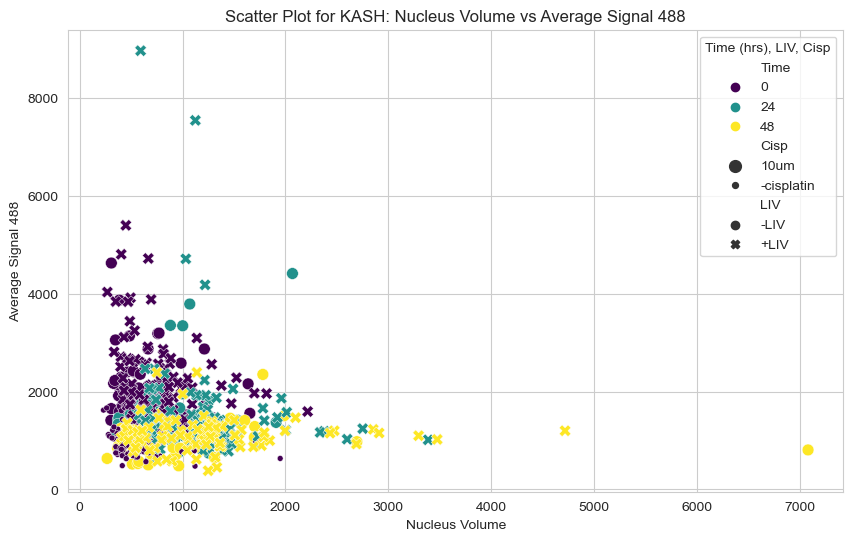

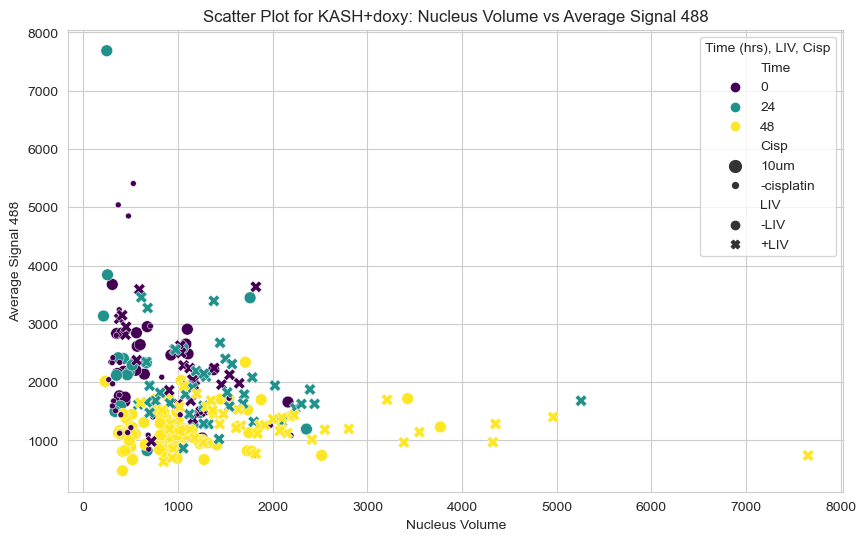

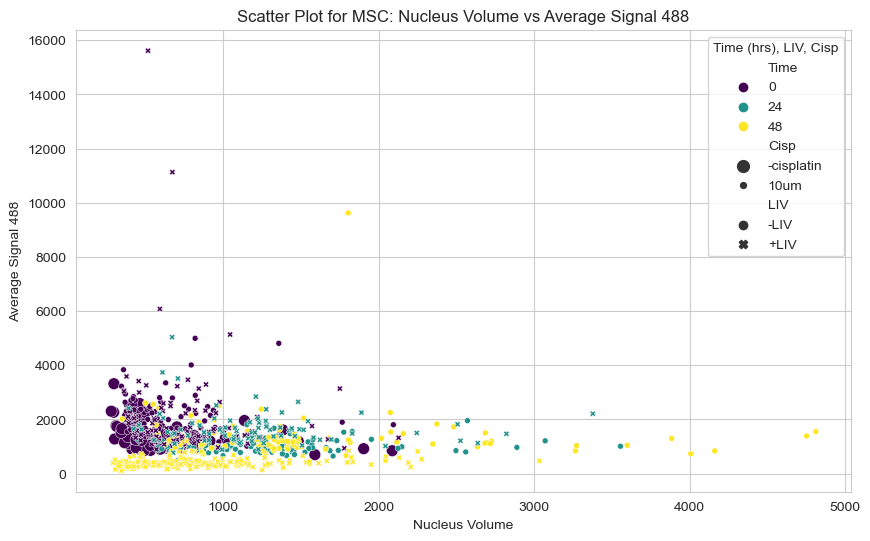

In [61]:
cell_types = final_df['Cell Type'].unique()

# Create a scatter plot for each cell type
for cell_type in cell_types:
    # Filter the DataFrame for the current cell type
    df_cell = final_df[final_df['Cell Type'] == cell_type]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_cell, x='Nucleus_volume', y='Average_signal_488',
                    hue='Time', style='LIV', size='Cisp', palette='viridis')

    # Adding plot title and labels
    plt.title(f'Scatter Plot for {cell_type}: Nucleus Volume vs Average Signal 488')
    plt.xlabel('Nucleus Volume')
    plt.ylabel('Average Signal 488')

    # Show the plot
    plt.legend(title='Time (hrs), LIV, Cisp')
    plt.show()

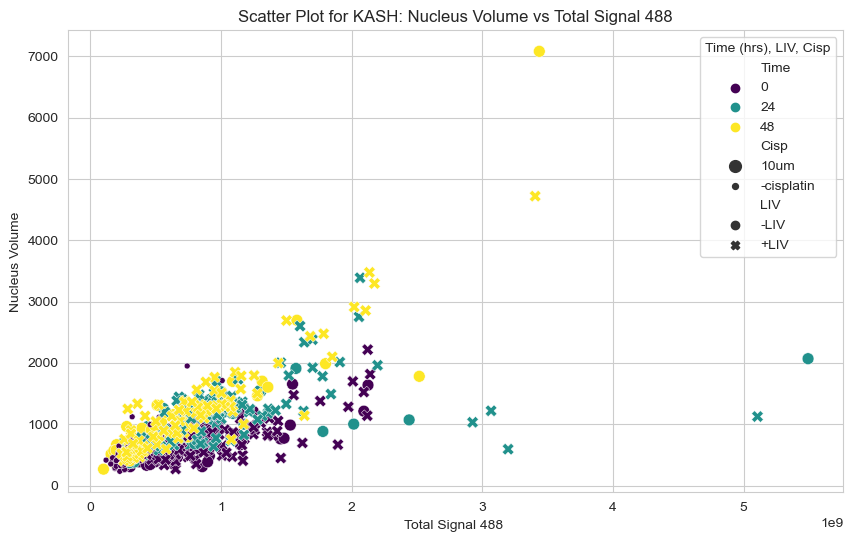

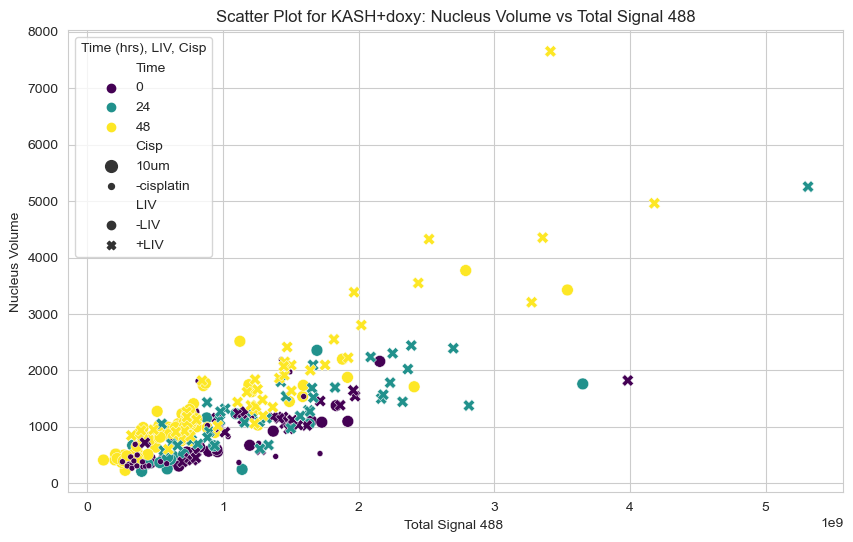

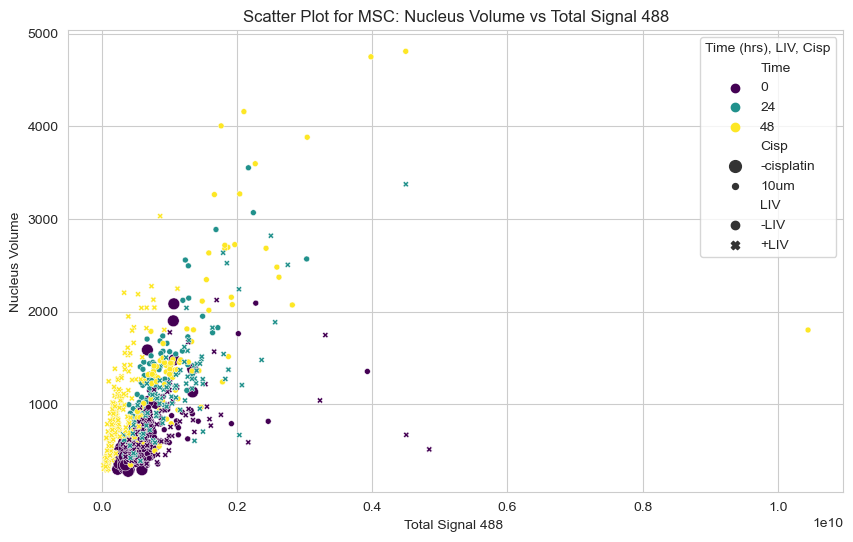

In [62]:
# Create a scatter plot for each cell type
for cell_type in cell_types:
    # Filter the DataFrame for the current cell type
    df_cell = final_df[final_df['Cell Type'] == cell_type]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_cell, x='Total_signal_488', y= 'Nucleus_volume',
                    hue='Time', style='LIV', size='Cisp', palette='viridis')

    # Adding plot title and labels
    plt.title(f'Scatter Plot for {cell_type}: Nucleus Volume vs Total Signal 488')
    plt.xlabel('Total Signal 488 ')
    plt.ylabel('Nucleus Volume')

    # Show the plot
    plt.legend(title='Time (hrs), LIV, Cisp')
    plt.show()

In [63]:
def calculate_correlations(df):
    correlation_avg_signal = df[['Nucleus_volume', 'Average_signal_488']].corr().iloc[0, 1]
    correlation_total_signal = df[['Nucleus_volume', 'Total_signal_488']].corr().iloc[0, 1]
    return pd.Series({'Correlation_Avg_Signal': correlation_avg_signal, 'Correlation_Total_Signal': correlation_total_signal})

# Group by 'Group' and apply the correlation function
correlation_table = final_df.groupby('Group').apply(calculate_correlations)

correlation_table


,Correlation_Avg_Signal,Correlation_Total_Signal
Group,,
KASH+doxy_+LIV_10um_0hr,-0.295275,0.770391
KASH+doxy_+LIV_10um_24hr,-0.215533,0.882930
KASH+doxy_+LIV_10um_48hr,-0.253757,0.889669
KASH+doxy_-LIV_-cisplatin_0hr,-0.337101,0.631689
KASH+doxy_-LIV_10um_0hr,-0.352013,0.824021
KASH+doxy_-LIV_10um_24hr,-0.274154,0.729212
KASH+doxy_-LIV_10um_48hr,0.168219,0.894144
KASH_+LIV_10um_0hr,-0.305033,0.740377
KASH_+LIV_10um_24hr,-0.222092,0.348300


C:\Users\nnina\AppData\Local\Temp\ipykernel_26636\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


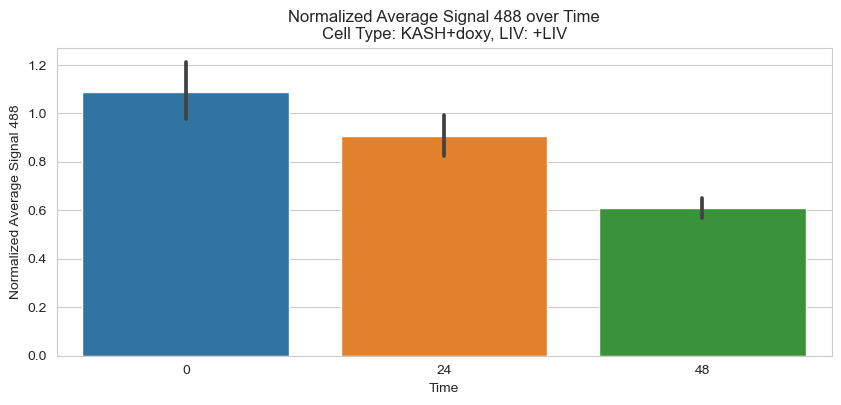

C:\Users\nnina\AppData\Local\Temp\ipykernel_26636\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


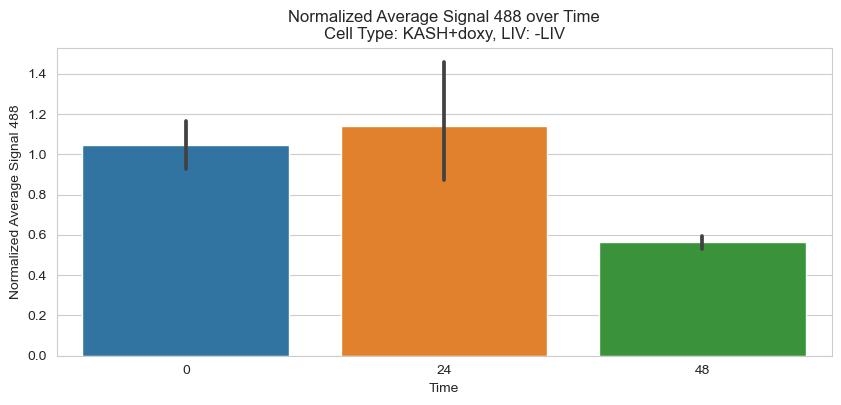

C:\Users\nnina\AppData\Local\Temp\ipykernel_26636\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


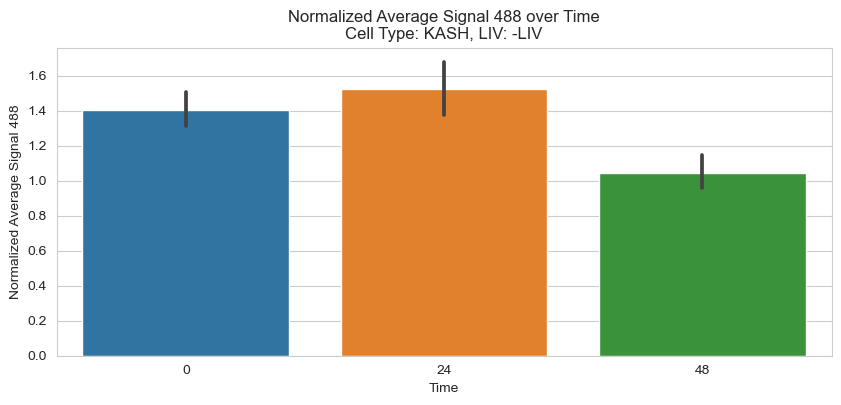

C:\Users\nnina\AppData\Local\Temp\ipykernel_26636\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


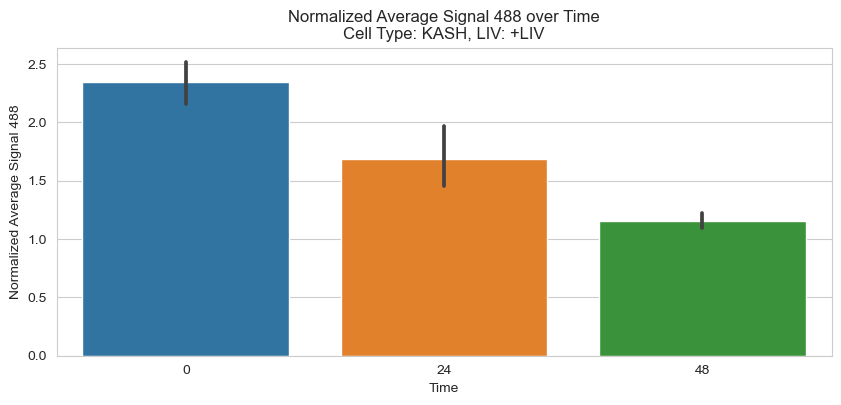

C:\Users\nnina\AppData\Local\Temp\ipykernel_26636\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


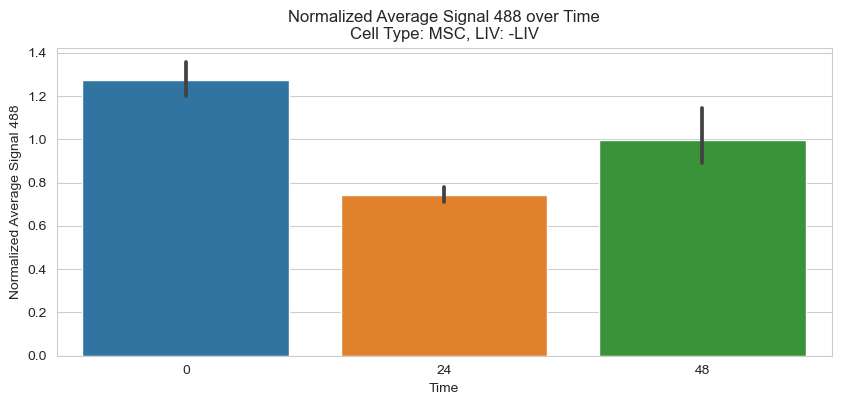

C:\Users\nnina\AppData\Local\Temp\ipykernel_26636\771360272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor


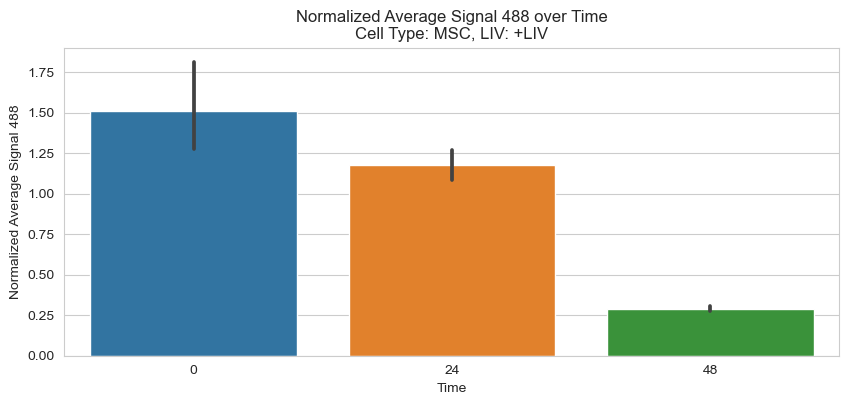

In [64]:
# Define the conditions for the bar charts
conditions = [
    {'Cell Type': 'KASH+doxy', 'LIV': '+LIV'},
    {'Cell Type': 'KASH+doxy', 'LIV': '-LIV'},
    {'Cell Type': 'KASH', 'LIV': '-LIV'},
    {'Cell Type': 'KASH', 'LIV': '+LIV'},
    {'Cell Type': 'MSC', 'LIV': '-LIV'},
    {'Cell Type': 'MSC', 'LIV': '+LIV'}
]

# Create bar charts
for condition in conditions:
    # Calculate the normalization factor based on condition
    normalization_factor = final_df[(final_df['Cell Type'] == condition['Cell Type']) &
                                    (final_df['Cisp'] == '-cisplatin') &
                                    (final_df['Time'] == 0) &
                                    (final_df['LIV'] == '-LIV')]['Average_signal_488'].mean()

    # Filter the DataFrame
    df_filtered = final_df[(final_df['Cell Type'] == condition['Cell Type']) &
                           (final_df['LIV'] == condition['LIV'])]

    # Normalize 'Average_signal_488'
    df_filtered['Normalized_Avg_Signal_488'] = df_filtered['Average_signal_488'] / normalization_factor

    # Plot
    plt.figure(figsize=(10, 4))
    sns.barplot(x='Time', y='Normalized_Avg_Signal_488', data=df_filtered)
    plt.title(f"Normalized Average Signal 488 over Time\nCell Type: {condition['Cell Type']}, LIV: {condition['LIV']}")
    plt.xlabel('Time')
    plt.ylabel('Normalized Average Signal 488')
    plt.show()


In [65]:
lsm_df

,Base_image_name,Processing,Date,Time,Cell Type,LIV,Cisp,Img_num,Cell_num,Nucleus_volume,Nucleus_height,Average_signal_594,Ring_coefficient,Average_signal_488,Total_signal_488,Group,Ring
0,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-33,LSM,23-11-06,0,KASH,-LIV,10um,0,0,461.643895,3.91,864.017826,1.174846,2401.808432,6.672365e+08,KASH_-LIV_10um_0hr,False
1,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-33,LSM,23-11-06,0,KASH,-LIV,10um,0,1,483.243250,3.45,561.337495,1.124206,3135.247164,9.117419e+08,KASH_-LIV_10um_0hr,False
2,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,0,584.321411,4.83,497.096685,1.603310,3898.721917,1.370908e+09,KASH_-LIV_10um_0hr,True
3,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,1,586.277123,5.52,486.145889,1.850022,3216.833939,1.134922e+09,KASH_-LIV_10um_0hr,True
4,LSMprocessed-23-11-06KASH-LIV10uM6xvib0hr-28,LSM,23-11-06,0,KASH,-LIV,10um,1,2,526.012718,7.13,182.770924,1.042673,2405.867156,7.615566e+08,KASH_-LIV_10um_0hr,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,2,784.626002,5.98,123.987522,0.928179,305.384805,1.441931e+08,MSC_+LIV_10um_48hr,False
1977,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,3,425.651624,5.29,106.588674,0.839584,264.252680,6.768743e+07,MSC_+LIV_10um_48hr,False
1978,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,4,329.505587,5.75,127.809957,0.915964,277.313742,5.498807e+07,MSC_+LIV_10um_48hr,False
1979,LSMprocessed-23-11-06MSC+LIV10um6xvib48hr-31(4),LSM,23-11-06,48,MSC,+LIV,10um,48,5,450.213248,5.29,128.939479,0.921926,435.221600,1.179134e+08,MSC_+LIV_10um_48hr,False


### Analysis of KASH+DOXY cells

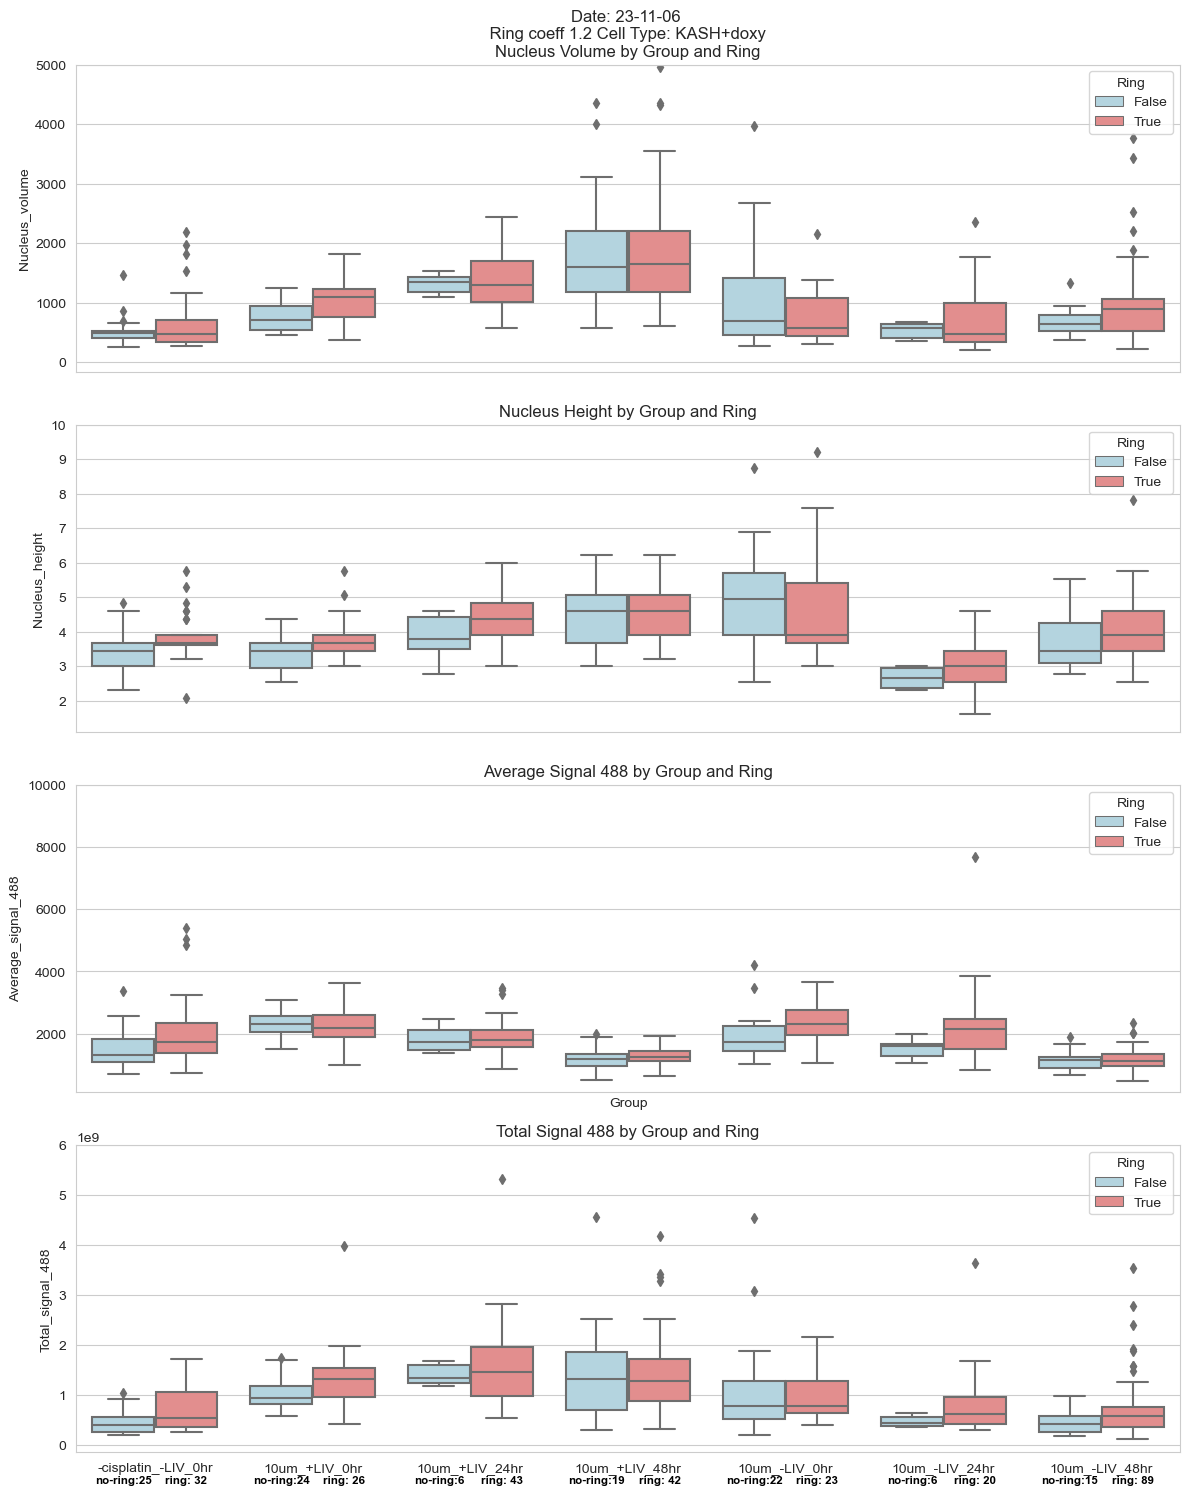

In [66]:
type_to_analyse = 'KASH+doxy'
fig = plot_metrics_by_group_and_ring(type_to_analyse, lsm_df, RING_COEFF_CUT_OFF,  color1="lightblue", color2="lightcoral",
                                     y_max_nucleus_volume=5000, y_max_nucleus_high=10,y_max_avg_signal_488=10000, y_max_total_signal_488=0.6e10)
plt.show()

### Analysis of KASH cells

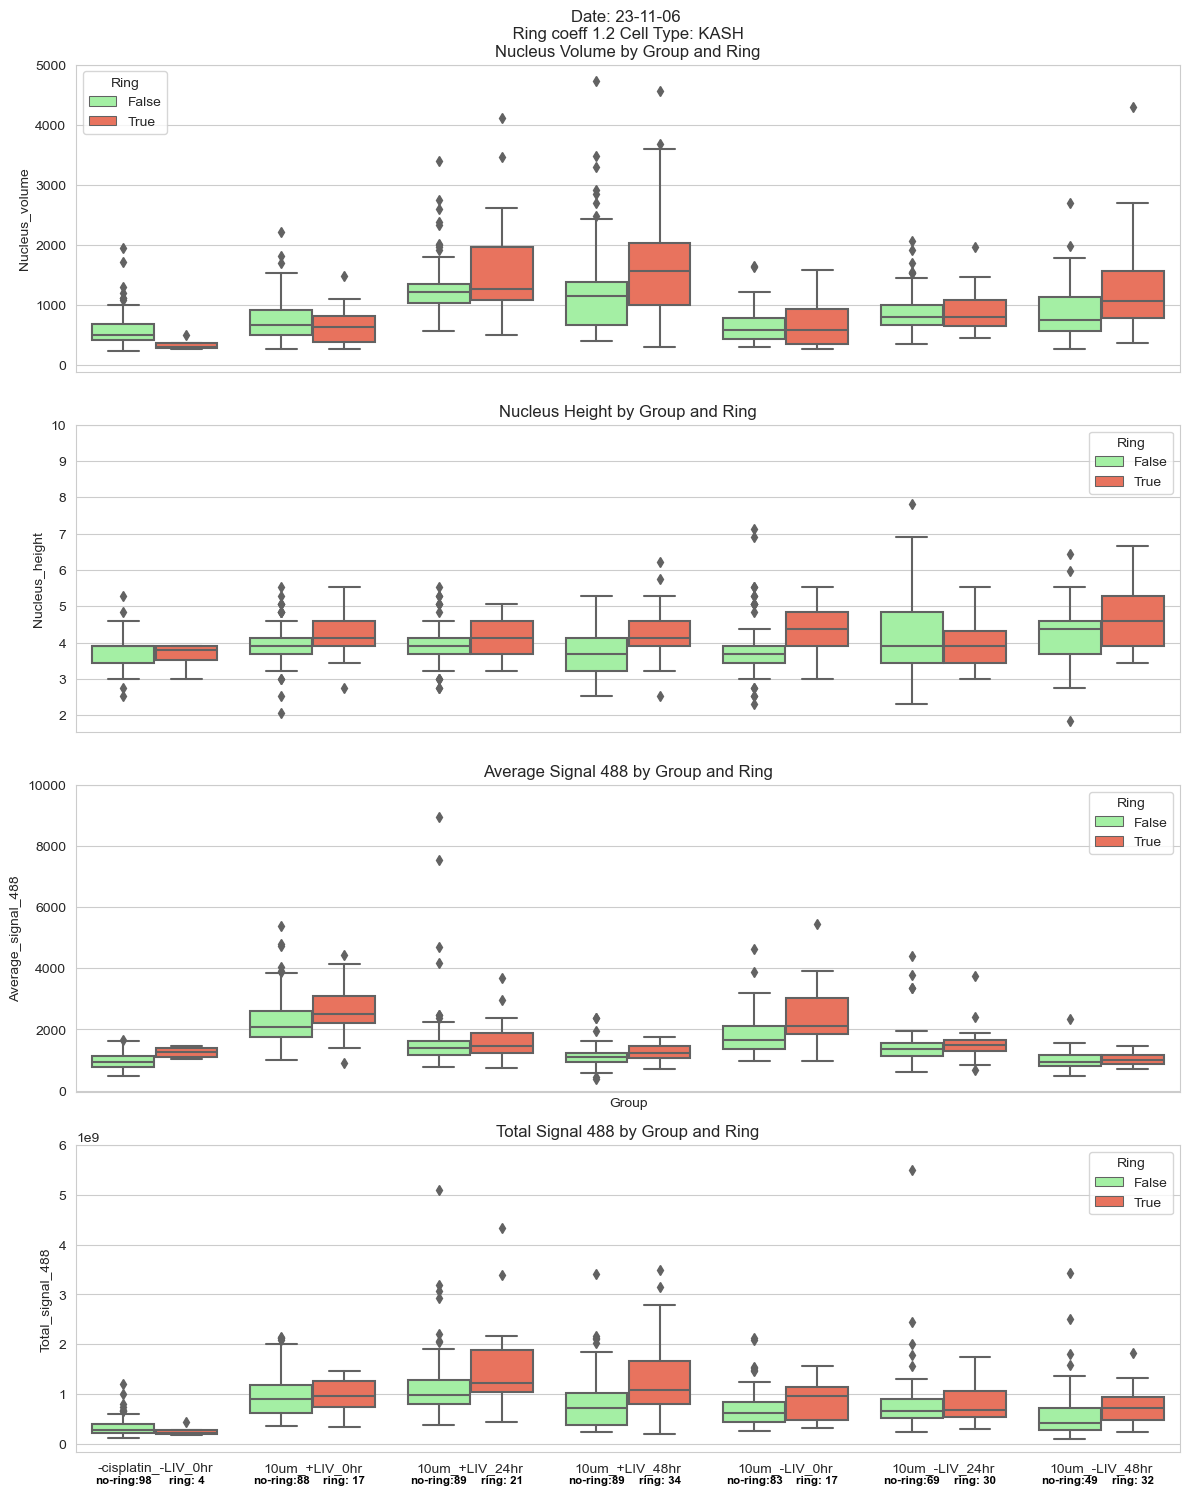

In [67]:
type_to_analyse = 'KASH'
fig = plot_metrics_by_group_and_ring(type_to_analyse, lsm_df, RING_COEFF_CUT_OFF,  color1="palegreen", color2="tomato",
                                     y_max_nucleus_volume=5000, y_max_nucleus_high=10, y_max_avg_signal_488=10000, y_max_total_signal_488=0.6e10)
plt.show()

### Analysis of MSC cells

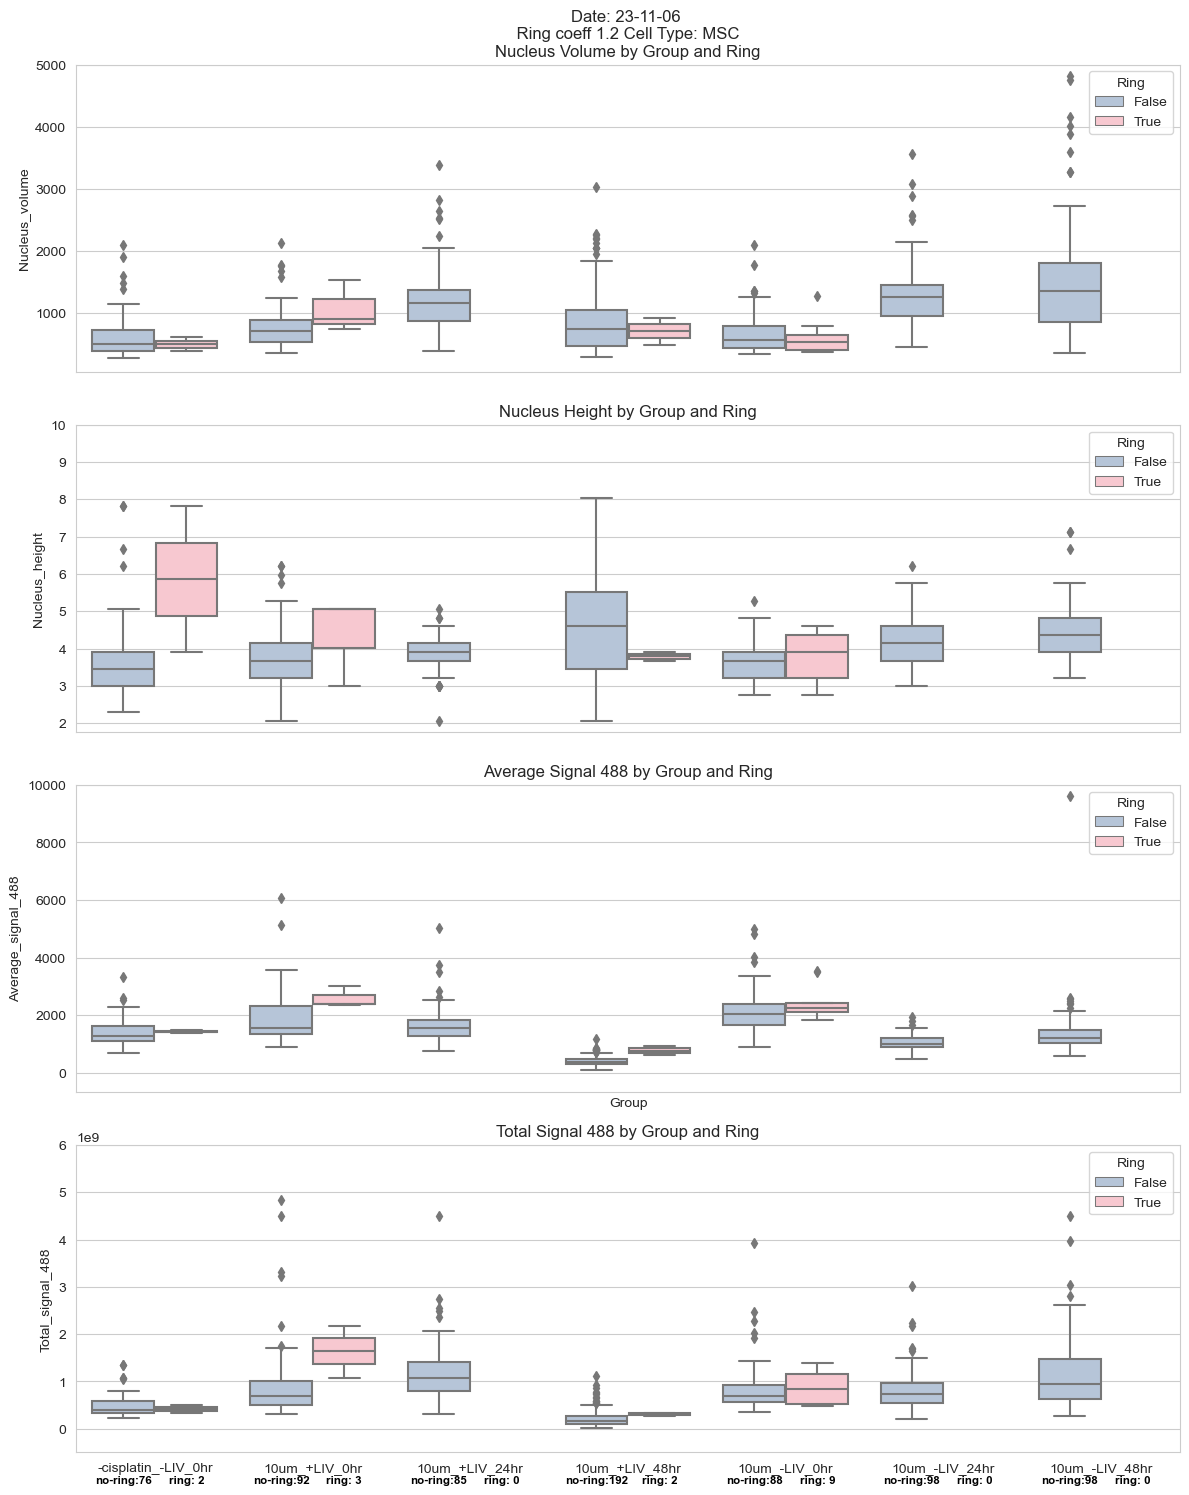

In [68]:
type_to_analyse = 'MSC'
fig = plot_metrics_by_group_and_ring(type_to_analyse, lsm_df, RING_COEFF_CUT_OFF,  color1="lightsteelblue", color2="pink",
                                     y_max_nucleus_volume=5000, y_max_nucleus_high=10, y_max_avg_signal_488=10000, y_max_total_signal_488=0.6e10)
plt.show()

In [69]:
### Investigate ring or no ring criterias

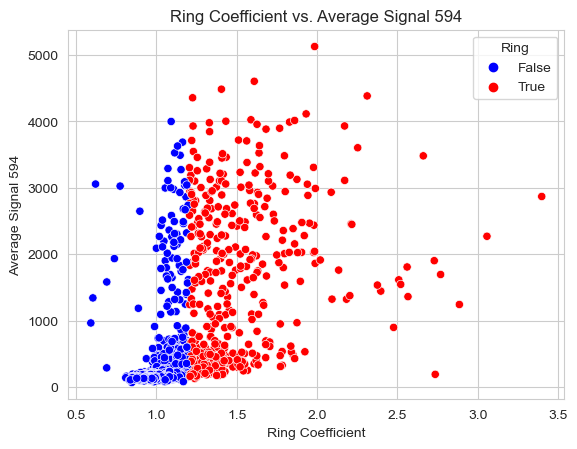

In [70]:
sns.scatterplot(data=lsm_df, x='Ring_coefficient', y='Average_signal_594', hue='Ring', palette=['blue', 'red'])

# Adding titles and labels for clarity
plt.title('Ring Coefficient vs. Average Signal 594')
plt.xlabel('Ring Coefficient')
plt.ylabel('Average Signal 594')

# Display the plot
plt.show()



In [71]:
# between 'Ring_coefficient' and 'Average_signal_594' for each group
grouped_correlation = lsm_df.groupby('Group')[['Ring_coefficient', 'Average_signal_594']].corr().iloc[0::2, -1].reset_index()

# Adjusting the columns for clarity
grouped_correlation.columns = ['Group', 'Variable', 'Correlation with Average_signal_594']
grouped_correlation = grouped_correlation.drop(columns=['Variable']).reset_index(drop=True)
grouped_correlation

,Group,Correlation with Average_signal_594
0,KASH+doxy_+LIV_10um_0hr,0.522701
1,KASH+doxy_+LIV_10um_24hr,0.189217
2,KASH+doxy_+LIV_10um_48hr,0.462253
3,KASH+doxy_-LIV_-cisplatin_0hr,0.208285
4,KASH+doxy_-LIV_10um_0hr,0.131398
5,KASH+doxy_-LIV_10um_24hr,-0.181185
6,KASH+doxy_-LIV_10um_48hr,0.193477
7,KASH_+LIV_10um_0hr,0.251017
8,KASH_+LIV_10um_24hr,0.631925
9,KASH_+LIV_10um_48hr,0.764988


C:\Users\nnina\miniconda3\envs\mal_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\nnina\AppData\Local\Temp\ipykernel_26636\3234668246.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Cluster')


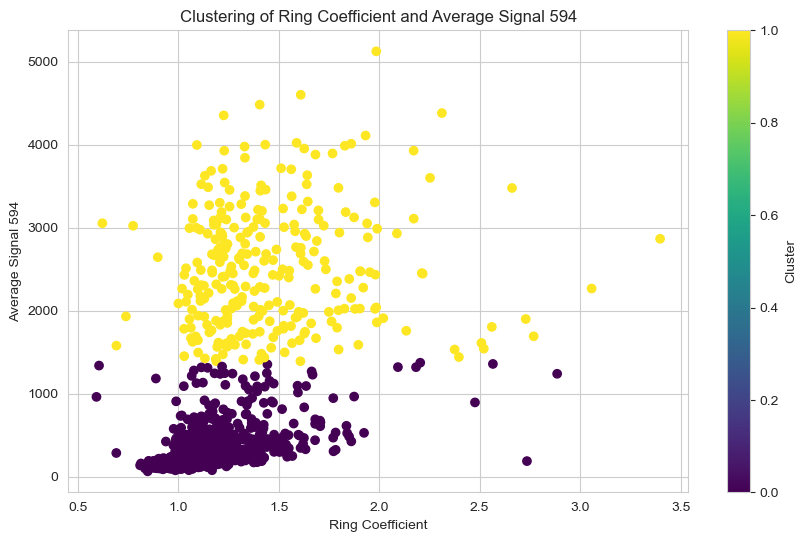

In [72]:
# Preparing data for clustering
X = lsm_df[['Ring_coefficient', 'Average_signal_594']]

# Applying K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Assigning cluster labels to the original data
lsm_df['Cluster'] = kmeans.labels_

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(lsm_df['Ring_coefficient'], lsm_df['Average_signal_594'], c=lsm_df['Cluster'], cmap='viridis', marker='o')
plt.title('Clustering of Ring Coefficient and Average Signal 594')
plt.xlabel('Ring Coefficient')
plt.ylabel('Average Signal 594')
plt.colorbar(label='Cluster')
plt.show()


## Subproject Overview
The objective of this project is to assess the presence or absence of a ring in the red channel of cells, utilizing a dataset comprising 41 3D czi images. This dataset encapsulates a total of 266 cells. The evaluation process will involve a detailed analysis conducted by two reviewers, Sean and Shayla, under the guidance of Anamaria. The analysis aims to categorize each cell based on the presence or absence of a ring on the red channel.

### Data Preparation and Methodology
#### Data Provision:
A comprehensive list detailing all 266 cells, inclusive of image names and cell numbers, will be provided. Additionally, png images with labeled cell numbers and the original czi images will be supplied for thorough investigation.
#### Training and Testing Sets:
The dataset will be randomly divided into two subsets: 80% for training (approximately 213 cells) and 20% for testing (approximately 53 cells).
### Analytical Methods
#### Threshold Analysis for 'Ring Coefficient':

This involves determining an optimal threshold for the "Ring Coefficient" using the training set. The decision might be supported by analyzing two histograms.

#### Clustering Approach:

A clustering method will be applied based on "Red Channel Intensity" and "Ring Coefficient". Analysis of a scatter plot, colored by the hue of human labeling, will help identify challenging cases and disagreements between reviewers.

#### Random Forest Model:

A random forest model will be developed, utilizing all available features. The impact of including the volume feature on the model's accuracy will also be explored.

### Accuracy Assessment
The accuracy of all three predictive methods will be calculated. Additionally, an innovative approach to assess human accuracy will be implemented, considering Sean's expertise as the benchmark (gold standard) and Shayla's input as representative of a novice researcher's perspective.
Professional Evaluation

### Strengths:
#### Comprehensive Data Analysis:
The project adopts a multi-faceted approach, employing statistical, clustering, and machine learning methods, which enhances the robustness of the findings.
#### Human Element:
Including human reviewers adds a valuable layer of qualitative analysis, enriching the dataset with expert and novice perspectives.

### Areas for Improvement:
#### Reviewer Bias Mitigation:
To further strengthen the study, incorporating more reviewers could help mitigate individual bias and provide a broader consensus on cell classification.
#### Automated Pre-Processing:
Implementing automated pre-processing steps to standardize images before analysis could reduce variability and improve model performance.
#### Cross-Validation:
Employing cross-validation techniques within the training set could offer a more reliable estimation of model performance and generalizability.

### Conclusion
The project's structured approach, combining human insight with advanced analytical techniques, sets a solid foundation for accurately classifying cells based on the presence or absence of a ring on the red channel. By addressing the suggested improvements, the project could further enhance its methodological rigor and the reliability of its findings.